In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from triangle_gauss import *
from math import pi
import numpy as np
import scipy
import time
import os
from triangle import triangulate
from scipy.interpolate import griddata
from matplotlib.path import Path
from torch.utils.tensorboard import SummaryWriter
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from utilities import *
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
class Heat2d_dg:
    def __init__(self, 
                 boundary_type: str = 'regular', 
                 Nint_elt: int=10, 
                 Nint_edge: int = 20,
                 N_t: int = 10,
                 order: int=2, 
                 partition: float=0.2) -> None:
        self.name = f'DG_2dHeat_{boundary_type}_{Nint_elt}_{Nint_edge}_{order}_{partition}'
        self.genmesh = GenMesh2D(boundary_type=boundary_type, Nint_edge=Nint_edge, Nint_elt=Nint_elt, param=f'pq30a{partition}e')
        self.torch_type = torch.float64
        #
        self.Nelt = self.genmesh.Nelt
        self.Nt = N_t
        self.time = torch.linspace(0, 1.0, N_t  + 1).to(device)
        #
        self.test_func = TestFunction2D()
        self.elt_int, self.elt_weights, self.edges_int, self.mesh_edges_w, self.mesh_normvec, self.xMesh, self.ref_Mesh, self.inv_matrix = self.genmesh.get_mesh()
        self.Mesh = torch.cat((self.xMesh[:, None, ...].expand(-1, N_t + 1, -1, -1), 
                               self.time[None, :, None, None].expand(self.xMesh.shape[0], -1, self.xMesh.shape[1], -1)), dim=-1)
        self.num_eltinnerp = self.genmesh.num_eltp
        self.num_eltbdp = self.genmesh.num_edgep
        # case 1
        if boundary_type == 'regular':
            self.func_f = lambda x, y, t: pi*(-torch.sin(pi*t) + 8*pi*torch.cos(pi*t))*torch.sin(2*pi*x)*torch.sin(2*pi*y)
            # self.func_f = lambda x, y: torch.zeros_like(x)
            self.func_init_u = lambda mesh: torch.sin(2 * pi * mesh[..., [0]]) * torch.sin(2 * pi * mesh[..., [1]])
            self.exact_u = lambda x, y, t: torch.sin(2*pi*x)*torch.sin(2*pi*y) * torch.cos(pi*t)
        else:
            return NotImplementedError
            
        # [degree, points_elt], [degree, 3, points_bd], [degree, elements, points_elt, 2]
        self.v_elt_inner, self.v_elt_bd, self.dv_elt_inner = self.get_test(order=order)
        #
        self.f = self.func_f(self.Mesh[..., [0]], self.Mesh[..., [1]], self.Mesh[..., [2]])
        self.f_inner = self.f[:, :, :self.num_eltinnerp, :]
        self.init_u = self.func_init_u(self.Mesh[:, 0, :, :2])
        #
        self.model = DGNet(num_modules=self.Nelt, input_size=3, hidden_size=50, output_size=1, num_layers=2, act='tanh').to(device).to(self.torch_type)
        # self.model_p = DGNet(num_modules=self.Nelt, input_size=3, hidden_size=50, 
        #                      output_size=2, num_layers=2, act='tanh').to(device).to(self.torch_type)
        #
        self.Lfbgs = torch.optim.LBFGS(self.model.parameters(), lr=1.0, max_iter=50000, 
                                           max_eval=50000, history_size=50, tolerance_grad=1e-7, 
                                           tolerance_change=1.0 * np.finfo(float).eps, 
                                           line_search_fn='strong_wolfe'); self.lfbgsiter = 0
        self.Adam = torch.optim.Adam(self.model.parameters(), lr=1e-4); self.maxiter = 10000; self.adamiter = 0
    
    def get_test(self, order: int=2):
        v, dv = self.test_func.Poly(mesh=self.ref_Mesh, order=order)
        v_elt_inner, v_elt_bd = v[:, :self.num_eltinnerp], v[:, self.num_eltinnerp:].reshape(-1, 3, self.num_eltbdp)
        dv_elt_inner = dv[:, :self.num_eltinnerp, :]
        dv_elt_inner = torch.matmul(self.inv_matrix[None, :, None, :, :], dv_elt_inner[:, None, :, :].unsqueeze(-1)).squeeze(-1)
        return v_elt_inner, v_elt_bd, dv_elt_inner

    
    def loss(self):
        #
        Mesh = self.Mesh.clone().detach().requires_grad_(True).to(device)
        # print(Mesh[:,0,:,2])
        u = self.model(Mesh)
        du = torch.autograd.grad(u, Mesh, grad_outputs=torch.ones_like(u), create_graph=True)[0]

        u_bd = u[..., self.num_eltinnerp:, :].reshape(self.Nelt, self.Nt + 1, 3, self.num_eltbdp)
        du_inner = du[..., :self.num_eltinnerp, :2] # [Elements, Time, Points_elt, 2]
        ut_inner = du[..., :self.num_eltinnerp, 2:3]   # [Elements, Time, Points_elt, 1]
        du_bd = du[..., self.num_eltinnerp:, :2].reshape(self.Nelt, self.Nt + 1, 3, self.num_eltbdp, 2) # [Elements, Time, 3, Points_bd, 2]
        
        # compute local loss
        weak_u = (((ut_inner - self.f_inner)[None, ..., 0] * self.v_elt_inner[:, None, None, :] 
                   + (du_inner[None, ...] * self.dv_elt_inner[:, :, None, ...]).sum(dim=-1)) * self.elt_weights[None, :, None, :]).sum(dim=-1) 
        weak_u =  weak_u - (((du_bd * self.mesh_normvec[:, None, :, None, :]).sum(dim=-1))[None, ...] * self.v_elt_bd[:, None, None, :, :] * self.mesh_edges_w[None, :, None, ...]).sum(dim=(-2, -1))

        # weak_u = torch.topk(weak_u, k=int(0.5*self.Nt), dim=-1)[0]
        # weak_u = torch.topk(weak_u, k=int(0.5*self.Nelt), dim=1)[0]

        local_loss = torch.sum(weak_u**2)
        # print(local_loss)
        # flux loss
        delt_u = u_bd[self.genmesh.inner_label[:, 0, 0], :, self.genmesh.inner_label[:, 0, 1], :] - torch.flip(u_bd[self.genmesh.inner_label[:, 1, 0], :, self.genmesh.inner_label[:, 1, 1], :], dims=[-1])   
        delt_du = du_bd[self.genmesh.inner_label[:, 0, 0], :, self.genmesh.inner_label[:, 0, 1], :, :] - torch.flip(du_bd[self.genmesh.inner_label[:, 1, 0], :, self.genmesh.inner_label[:, 1, 1], :, :], dims=[-2])
        
        flux_loss = torch.sum(delt_u**2) + torch.sum(delt_du**2)
        # print(flux_loss)
        # init loss
        init_loss = torch.sum((u[:, 0, :, 0] - self.init_u[..., 0])**2)
        # print(init_loss)
        # boundary loss
        bd_loss = torch.sum(u_bd[self.genmesh.bd_label[:, 0, 0], :, self.genmesh.bd_label[:, 0, 1], :] ** 2) 
        # print('pass')
        # print(local_loss.item(), flux_loss.item(), bd_loss.item(), init_loss.item())
        loss = 10 * local_loss + flux_loss + bd_loss + init_loss
        return loss
        # mse = torch.mean((u - self.u_exact)**2)
        # mae = torch.max(torch.abs(u - self.u_exact))
        # return loss, mse, mae
    
    def loss_lfbgs(self):
        self.Lfbgs.zero_grad()
        # loss, mse, mae = self.loss()
        loss = self.loss()
        # self.writer.add_scalar(f"mse_vs_iter", mse, self.lfbgsiter + self.adamiter)
        # self.writer.add_scalar(f"mse_vs_time", mse, time.time() - self.t)
        loss.backward()
        self.lfbgsiter += 1
        if self.lfbgsiter % 100 == 0:
            # print(f"LBFGS At iter: {self.lfbgsiter}, loss_train:{loss.item():.6f}, mse:{mse.item():.6f}, mae:{mae.item():.6f}")
            print(f"LBFGS At iter: {self.lfbgsiter}, loss_train:{loss.item():.6f}")
        return loss
    
    def loss_adam(self):
        self.Adam.zero_grad()
        # loss, mse, mae = self.loss()
        loss = self.loss()
        # self.writer.add_scalar(f"mse_vs_iter", mse, self.lfbgsiter + self.adamiter)
        # self.writer.add_scalar(f"mse_vs_time", mse, time.time() - self.t)
        self.adamiter += 1
        if self.adamiter % 100 == 0:
            # print(f"Adam At iter: {self.adamiter}, loss_train:{loss.item():.6f}, mse:{mse.item():.6f}, mae:{mae.item():.6f}")
            print(f"Adam At iter: {self.adamiter}, loss_train:{loss.item():.6f}")
        return loss
    def train(self):
        print('*********** Started training ...... ***************')
        # self.writer = SummaryWriter(f'./logs/possion2d/DGNet')
        self.t = time.time()
        self.Lfbgs.step(self.loss_lfbgs)
        torch.save(self.model.state_dict(), f'./models/DGNet/{self.name}.pth')
        loss = self.loss_adam()
        best_loss = loss
        while loss > 1e-5:
            loss.backward()
            self.Adam.step()
            loss = self.loss_adam()
            if loss < best_loss:
                best_loss = loss
                torch.save(self.model.state_dict(), f'./models/DGNet/{self.name}.pth')
            if self.adamiter > self.maxiter:
                break
        self.adamiter = 0
        print(f'Finished training in {time.time()-self.t:.4f} seconds')
    def load(self):
        path = f'./models/DGNet/{self.name}.pth'
        if os.path.exists(path):
            print("Loading saved model...")
            model_dict = torch.load(path)
            self.model.load_state_dict(model_dict)
            return True
        else:
            print("No saved model found. Need to train")
            return False

p = Heat2d_dg(partition=0.1)
p.load()
p.loss()
p.train()

Loading saved model...
*********** Started training ...... ***************
LBFGS At iter: 100, loss_train:0.046971
LBFGS At iter: 200, loss_train:0.046818
LBFGS At iter: 300, loss_train:0.046666
LBFGS At iter: 400, loss_train:0.046519
LBFGS At iter: 500, loss_train:0.046369
LBFGS At iter: 600, loss_train:0.046221
LBFGS At iter: 700, loss_train:0.046053
LBFGS At iter: 800, loss_train:0.045896
LBFGS At iter: 900, loss_train:0.045741
LBFGS At iter: 1000, loss_train:0.045578
LBFGS At iter: 1100, loss_train:0.045414
LBFGS At iter: 1200, loss_train:0.045254
LBFGS At iter: 1300, loss_train:0.045105
LBFGS At iter: 1400, loss_train:0.044959
LBFGS At iter: 1500, loss_train:0.044822
LBFGS At iter: 1600, loss_train:0.044707
LBFGS At iter: 1700, loss_train:0.044588
LBFGS At iter: 1800, loss_train:0.044450
LBFGS At iter: 1900, loss_train:0.044323
LBFGS At iter: 2000, loss_train:0.044206
LBFGS At iter: 2100, loss_train:0.044079
LBFGS At iter: 2200, loss_train:0.043921
LBFGS At iter: 2300, loss_train:

In [43]:
# problem = Heat2d_dg(order=2, partition=0.1)
# model = DGNet(num_modules=problem.Nelt, input_size=3, hidden_size=50, 
#                             output_size=1, num_layers=2, act='tanh').to(device).to(problem.torch_type)
# model.load_state_dict(torch.load(f'./models/DGNet/{problem.name}.pth'))
# x = problem.Mesh.clone().detach().requires_grad_(True).to(device)
# y = model(x) # [Elements, Time, Points, 1]

# x = x[:, 0, :, :2].reshape(-1, 2).detach().cpu().numpy()
# y = y[:, 9, :, 0].detach().cpu().numpy()
# # assert np.all(np.isfinite(x)) and np.all(np.isfinite(y))
# f = problem.f
# plt.tricontourf(x[:, 0], x[:, 1], y.flatten(), cmap='jet', levels=100)
# plt.colorbar()

In [44]:
from matplotlib.tri import Triangulation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

problem = Heat2d_dg(order=2, partition=0.1)
model = DGNet(num_modules=problem.Nelt, input_size=3, hidden_size=50, output_size=1, num_layers=2, act='tanh').to(device).to(problem.torch_type)
model.load_state_dict(torch.load(f'./models/DGNet/{problem.name}.pth'))
# 1. 预处理网格与解
Nt = 100
t = torch.linspace(0, 1.0, Nt + 1).to(device)
x = problem.xMesh.clone().detach().to(device)
Mesh = torch.cat((x[:, None, ...].expand(-1, Nt + 1, -1, -1), t[None, :, None, None].expand(x.shape[0], -1, x.shape[1], -1)), dim=-1).to(device)
y = model(Mesh)  # shape: [Elements, Time, Points, 1]

# 抽取静态网格坐标 (time-independent)
x_plot = Mesh[:, 0, :, :2].reshape(-1, 2).detach().cpu().numpy()
tri = Triangulation(x_plot[:, 0], x_plot[:, 1])

# 抽取所有时间步解
y_all = y.detach().cpu().numpy()   # shape: [Elements, Time, Points, 1]
y_all = y_all[:, :, :, 0].transpose(1, 0, 2).reshape(Nt + 1, -1)  # shape: [Time, (Elements * Points)]

# 设置统一颜色范围
vmin = y_all.min()
vmax = y_all.max()

# 2. 创建动画
fig, ax = plt.subplots(figsize=(6, 5))
cmap = plt.get_cmap('jet')
contour = ax.tricontourf(tri, y_all[0], cmap=cmap, levels=100, vmin=vmin, vmax=vmax)
cb = fig.colorbar(contour)
title = ax.set_title("Time step: 0")

def update(i):
    ax.clear()
    contour = ax.tricontourf(tri, y_all[i], cmap=cmap, levels=100, vmin=vmin, vmax=vmax)
    title = ax.set_title(f"Time step: {i}")
    return contour.collections + [title]

ani = FuncAnimation(fig, update, frames=Nt + 1, interval=200, blit=False)
plt.close(fig)  # 防止重复静态图输出
HTML(ani.to_jshtml())

/root/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [45]:
ani.save('./pics/heat2d.gif', writer='pillow', fps=20)

/root/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/tmp/ipykernel_1627/1424930027.py:97: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()  # 触发布局更新（无论你用了 constrained_layout 还是 tight_layout）


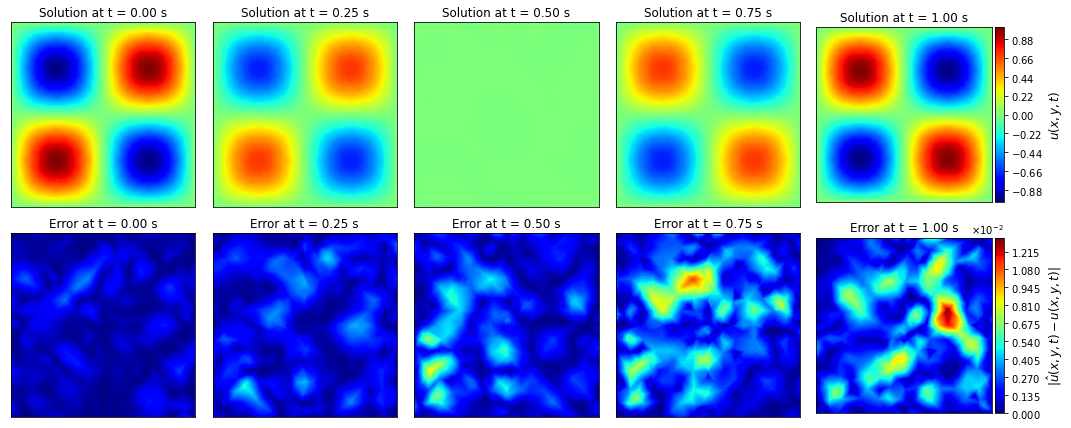

In [42]:
import torch
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

# 加载模型与数据
problem = Heat2d_dg(order=2, partition=0.1)
model = DGNet(
    num_modules=problem.Nelt,
    input_size=3,
    hidden_size=50,
    output_size=1,
    num_layers=2,
    act='tanh'
).to(device).to(problem.torch_type)
model.load_state_dict(torch.load(f'./models/DGNet/{problem.name}.pth'))

# 时间设置
Nt = 4
t = torch.linspace(0, 1.0, Nt + 1).to(device)
x = problem.xMesh.clone().detach().to(device)

# 构建 mesh: [Ne, Nt+1, Np, 3]
Mesh = torch.cat(
    (
        x[:, None, ...].expand(-1, Nt + 1, -1, -1),
        t[None, :, None, None].expand(x.shape[0], -1, x.shape[1], 1)
    ),
    dim=-1
).to(device)

# 预测值与精确解
y_pred = model(Mesh)
y_exact = problem.exact_u(Mesh[..., [0]], Mesh[..., [1]], Mesh[..., [2]])

# 网格点：用 t=0 的坐标作为绘图坐标
x_plot = Mesh[:, 0, :, :2].reshape(-1, 2).cpu().numpy()
tri = Triangulation(x_plot[:, 0], x_plot[:, 1])

# reshape 成 [Nt+1, Ne*Np]
y_all = y_pred.detach().cpu().numpy()[..., 0].transpose(1, 0, 2).reshape(Nt + 1, -1)
y_exact_all = y_exact.detach().cpu().numpy()[..., 0].transpose(1, 0, 2).reshape(Nt + 1, -1)
error_all = abs(y_all - y_exact_all)

# 统一色标
vmin = y_all.min()
vmax = y_all.max()
err_max = error_all.max()

# 开始画图
fig, axes = plt.subplots(2, Nt + 1, figsize=(15, 6), constrained_layout=True)
cmap = plt.get_cmap('jet')

# 存储最后一列用于 colorbar 定位
tpc1 = None
tpc2 = None

for i in range(Nt + 1):
    # 第一行：预测值
    ax1 = axes[0, i]
    tpc1 = ax1.tricontourf(tri, y_all[i], cmap=cmap, levels=100, vmin=vmin, vmax=vmax)
    ax1.set_title(f"Solution at t = {t[i].item():.2f} s")
    ax1.set_aspect('equal')
    ax1.set_xticks([])
    ax1.set_yticks([])

    # 第二行：误差图
    ax2 = axes[1, i]
    tpc2 = ax2.tricontourf(tri, error_all[i], cmap='jet', levels=100, vmin=0.0, vmax=err_max)
    ax2.set_title(f"Error at t = {t[i].item():.2f} s")
    ax2.set_aspect('equal')
    ax2.set_xticks([])
    ax2.set_yticks([])

# Colorbar 格式器（科学计数法）
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-1, 0))

# 第一行 colorbar：预测值
divider1 = make_axes_locatable(axes[0, -1])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cb1 = plt.colorbar(tpc1, cax=cax1, format=formatter)
cb1.set_label(r'$u(x, y, t)$', fontsize=12)
cb1.ax.tick_params(labelsize=10)
cb1.ax.yaxis.get_offset_text().set_fontsize(10)

# 第二行 colorbar：误差
divider2 = make_axes_locatable(axes[1, -1])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cb2 = plt.colorbar(tpc2, cax=cax2, format=formatter)
cb2.set_label(r'$|\hat{u}(x, y, t) - u(x, y, t)|$', fontsize=12)
cb2.ax.tick_params(labelsize=10)
cb2.ax.yaxis.get_offset_text().set_fontsize(10)

# 显示并保存
plt.tight_layout()  # 触发布局更新（无论你用了 constrained_layout 还是 tight_layout）
plt.savefig('./pics/2dHeatmap.pdf', bbox_inches='tight')
plt.show()


